# Тестовое задание для "BostonGene"</br>
#### Дмитрий Зарубин

## 1. Сгенерировать набор данных
> Для создания набора использовал набор функций из "data_utils.py", затем сохранил сгененированные картинки и маски в 2 папки "Iamges" и "Masks"

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import dataset_utils

IMG_H = 160
IMG_W = 160
n_train = 5000
n_val = 500
n_test = 1000

batch_size = 24
num_workers = 2

ROOT = '../Segmentation_Data/Train'

In [4]:
# dataset_utils.create_dataset(
#     height=IMG_H, 
#     width=IMG_W, 
#     n_train=n_train,
#     n_val=n_val,
#     n_test=n_test,
#     root='../')

Directory |../Segmentation_Data|
Already exists! It will be removed
100%|██████████| 1000/1000 [00:05<00:00, 187.09it/s]


> Посмотрим что получилось:

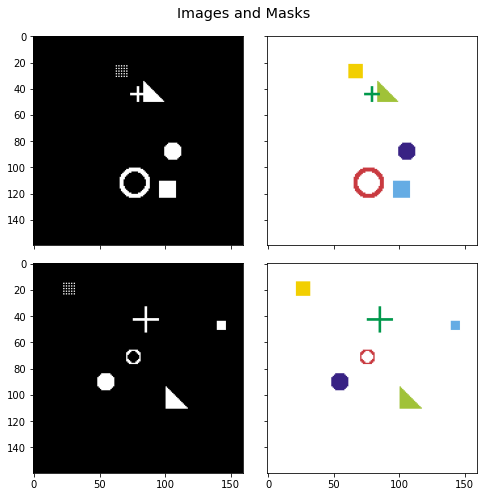

In [2]:
dataset_utils.plot_img_n_masks(ROOT, 2)

## 2.1. Инициализация Dataset и DataLoader

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[.0, .0, .0], 
        std=[1., 1., 1.])

])

train_set = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Train/', transforms=norm)
val_set = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Val/', transforms=norm)

train_loader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers
)

val_loader = DataLoader(
    dataset=val_set, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers
)

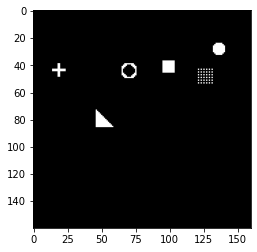

In [4]:
from evaluate import reverse_transform

inputs, masks = next(iter(train_loader))
idx = np.random.randint(0, batch_size - 1, 1)
plt.imshow(reverse_transform(inputs[idx][0]))
plt.show()

## 2.2. Модель
> В качестве алгоритма для классификации была выбрана модель Unet с уменьшенным количеством фильтров в каждом слое и немного измененными параметрами свертки. </br>Глобально: меньшее кол-во фильтров,так как сегментироваться будут не столь "абстрактные" обьекты, измененные параметры свертки - чтобы не кропать изображение во время конкатенации слоев.

In [4]:
from torchsummary import summary
import torch
import torch.nn as nn
from unet import UNet

device = 'cuda'

model = UNet().to(device)

summary(model, input_size=(3, IMG_H, IMG_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 160]             432
       BatchNorm2d-2         [-1, 16, 160, 160]              32
              ReLU-3         [-1, 16, 160, 160]               0
            Conv2d-4         [-1, 16, 160, 160]           2,304
       BatchNorm2d-5         [-1, 16, 160, 160]              32
              ReLU-6         [-1, 16, 160, 160]               0
         MaxPool2d-7           [-1, 16, 80, 80]               0
            Conv2d-8           [-1, 32, 80, 80]           4,608
       BatchNorm2d-9           [-1, 32, 80, 80]              64
             ReLU-10           [-1, 32, 80, 80]               0
           Conv2d-11           [-1, 32, 80, 80]           9,216
      BatchNorm2d-12           [-1, 32, 80, 80]              64
             ReLU-13           [-1, 32, 80, 80]               0
        MaxPool2d-14           [-1, 32,

## 2.3. Обучение и гиперпараметры.

In [5]:
import torch.optim as optim
from torch.optim import lr_scheduler

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
num_epochs = 40

In [7]:
from train import *

model, train_losses, val_losses = train_model(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)

Epoch 1/40
----------
LR: 0.001
Train: bce loss: 0.319973, dice loss: 0.966941, composite loss: 0.708154
Val: bce loss: 0.094843, dice loss: 0.916461, composite loss: 0.587814
=> Saving model
Validation loss decreased (inf --> 0.587814).
0m 33s
Epoch 2/40
----------
LR: 0.001
Train: bce loss: 0.029296, dice loss: 0.606814, composite loss: 0.375807
Val: bce loss: 0.002001, dice loss: 0.167695, composite loss: 0.101417
=> Saving model
Validation loss decreased (0.587814 --> 0.101417).
0m 32s
Epoch 3/40
----------
LR: 0.001
Train: bce loss: 0.001361, dice loss: 0.084257, composite loss: 0.051098
Val: bce loss: 0.001183, dice loss: 0.051581, composite loss: 0.031422
=> Saving model
Validation loss decreased (0.101417 --> 0.031422).
0m 32s
Epoch 4/40
----------
LR: 0.001
Train: bce loss: 0.001107, dice loss: 0.044293, composite loss: 0.027018
Val: bce loss: 0.001065, dice loss: 0.036567, composite loss: 0.022366
=> Saving model
Validation loss decreased (0.031422 --> 0.022366).
0m 33s
Epoch

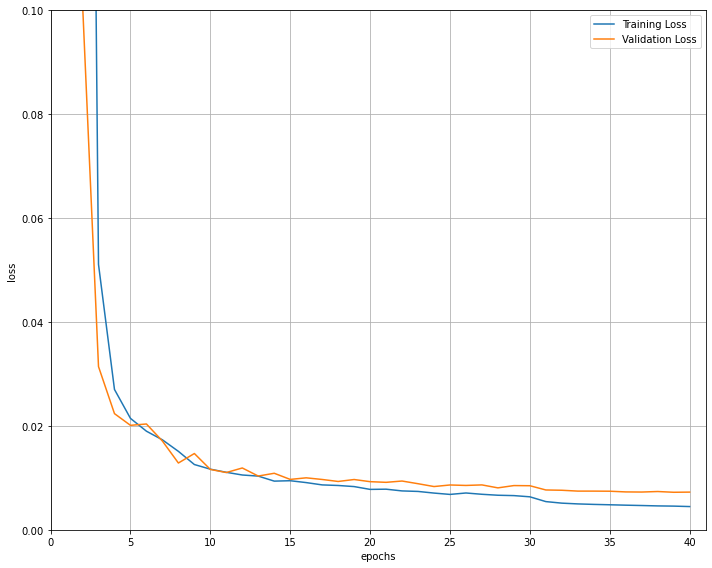

In [45]:
plot_loss(
    train_loss=train_losses,
    valid_loss=val_losses
)

In [6]:
test_dataset = dataset_utils.Segmentation_Dataset('../Segmentation_Data/Test/', transforms=norm)
model = torch.load('model.pth')

In [7]:
from evaluate import evaluate

evaluate(
    model=model, 
    loss_fn=loss_fn, 
    test_dataset=test_dataset,
    batch_size=24,
    path='../Segmentation_Data/Test/Predictions/', 
    device=device)

  0%|          | 0/42 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)